<a href="https://colab.research.google.com/github/konstanzer/deep-learning/blob/master/mobile_net_kerhaz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning using Mobilenet and Keras
Based on https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

In [41]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.applications import mobilenet_v2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from IPython.display import Image
from keras.applications import imagenet_utils
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Rather than manually downloading images for fine-tuned learning, use Bing Image Search via this import.

In [5]:
!pip install bing-image-downloader
from bing_image_downloader import downloader

In Ferhat Kulfaz's notebook, he shows an example of using MobileNet to classify images of dogs and an example when it misclassifies an image of a blue tit. He retrains MobileNet via transfer learning and correctly classifies the tit. Only two classifiers are employed but this can be extended to as many as you want, limited only by hardware and time available.

The source paper for MobileNet is located here: https://arxiv.org/pdf/1704.04861.pdf

MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications, Howard et al, 2017.

MobileNet is a lightweight architecture. It uses depthwise separable convolutions - separate convolutions on each colour channel rather than flattening all three. This has the effect of filtering the input channels.

"For MobileNets the depthwise convolution applies a single filter to each input channel. The pointwise convolution then applies a 1×1 convolution to combine the outputs the depthwise convolution. A standard convolution both filters and combines inputs into a new set of outputs in one step. The depthwise separable convolution splits this into two layers, a separate layer for filtering and a separate layer for combining. This factorization has the effect of drastically reducing computation and model size.”

In [9]:
mobile = mobilenet_v2.MobileNetV2()
img_path='/content/drive/MyDrive/Colab Notebooks/data/birds/'

In [10]:
def prepare_image(file):
  img = image.load_img(file, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array_expanded = np.expand_dims(img_array, axis=0)
  return mobilenet_v2.preprocess_input(img_array_expanded)

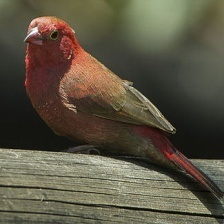

In [11]:
filename = img_path+'images to test/1.jpg'
Image(filename)

In [40]:
imagenet_utils.decode_predictions(mobile.predict(prepare_image(filename)))

[[('n01532829', 'house_finch', 0.31254074),
  ('n01828970', 'bee_eater', 0.08511776),
  ('n01560419', 'bulbul', 0.020342592),
  ('n01530575', 'brambling', 0.013834301),
  ('n01531178', 'goldfinch', 0.012033349)]]

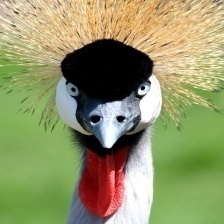

In [33]:
filename = img_path+'images to test/2.jpg'
Image(filename)

In [34]:
imagenet_utils.decode_predictions(mobile.predict(prepare_image(filename)))

[[('n02012849', 'crane', 0.88266975),
  ('n01855672', 'goose', 0.008072745),
  ('n01616318', 'vulture', 0.0057985377),
  ('n02051845', 'pelican', 0.0049014343),
  ('n02497673', 'Madagascar_cat', 0.004205381)]]

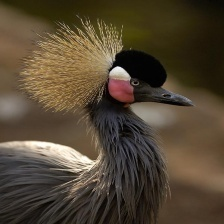

In [47]:
filename = img_path+'images to test/5.jpg'
Image(filename)

In [48]:
imagenet_utils.decode_predictions(mobile.predict(prepare_image(filename)))

[[('n02012849', 'crane', 0.963681),
  ('n01518878', 'ostrich', 0.00398427),
  ('n01855032', 'red-breasted_merganser', 0.0036345602),
  ('n02009229', 'little_blue_heron', 0.0021106256),
  ('n02488702', 'colobus', 0.0012718011)]]

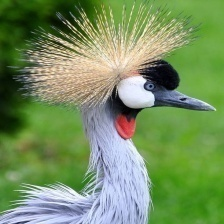

In [42]:
filename = img_path+'images to test/4.jpg'
Image(filename)

In [43]:
imagenet_utils.decode_predictions(mobile.predict(prepare_image(filename)))

[[('n02012849', 'crane', 0.95138943),
  ('n02009229', 'little_blue_heron', 0.0024413108),
  ('n02009912', 'American_egret', 0.0012066208),
  ('n01616318', 'vulture', 0.0011594463),
  ('n01855032', 'red-breasted_merganser', 0.0011310334)]]

## Transfer learning
Let us now manipulate the MobileNet architecture while retraining the top few layers. To do this, we need to train it on some images. Here I will train it on scarlet tanagers and grey crowned cranes. But

In [ ]:
#you'll have to delete a few images after they download
downloader.download("scarlet tanager", limit=50, output_dir=img_path+'datasets')
downloader.download("grey crowned crane", limit=50, output_dir=img_path+'datasets')

Lets now re-use MobileNet as it is quite lightweight (17Mb), freeze the base layers and lets add and train the top few layers. Note I shall only train two classifiers, the tanager and the crane.

In [26]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet',
                                      include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
base_model.trainable =  False

x = base_model.output
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = tfl.Dense(1024,activation='relu')(x) #dense layer 2
x = tfl.Dense(512,activation='relu')(x) #dense layer 3
preds = tfl.Dense(2,activation='softmax')(x) #final layer with softmax activation

In [27]:
model = Model(inputs=base_model.input, outputs=preds)

In [ ]:
model.summary()

In [29]:
freeze_layers = 20
for layer in model.layers[freeze_layers:]:
  layer.trainable=True

In [33]:
train_datagen = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input) #included in our dependencies
train_generator = train_datagen.flow_from_directory(img_path+'datasets',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 76 images belonging to 2 classes.


In [40]:
model.compile(optimizer=Adam(learning_rate=.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
model.fit(train_generator,
          steps_per_epoch=step_size_train,
          epochs=10)

Epoch 1/10
2/2 [==============================] - 12s 4s/step - loss: 0.0780 - accuracy: 0.9773
Epoch 2/10
2/2 [==============================] - 9s 4s/step - loss: 0.6245 - accuracy: 0.9219
Epoch 3/10
2/2 [==============================] - 7s 4s/step - loss: 0.4312 - accuracy: 0.9318
Epoch 4/10
2/2 [==============================] - 9s 4s/step - loss: 0.2471 - accuracy: 0.9375
Epoch 5/10
2/2 [==============================] - 10s 4s/step - loss: 0.0145 - accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 7s 5s/step - loss: 0.0187 - accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 9s 4s/step - loss: 0.0105 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 7s 4s/step - loss: 5.2152e-04 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 7s 5s/step - loss: 1.4810e-04 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 7s 2s/step - loss: 0.0047 - accuracy: 1.0000


In [66]:
def predict_image(img_path, show=True):
  img = image.load_img(img_path, target_size=(224, 224))
  img_tensor = image.img_to_array(img)                    # (height, width, channels)
  img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
  img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
  if show:
      plt.imshow(img_tensor[0])                           
      plt.axis('off')
      plt.show()

  class_names=['tanager', 'crane']
  prediction = model(img_tensor)
  print("Class prediction vector = ", np.round(prediction.numpy(),4))
  print("Class: ", class_names[np.argmax(prediction)])

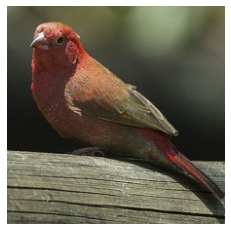

Class prediction vector =  [[1. 0.]]
Class:  tanager


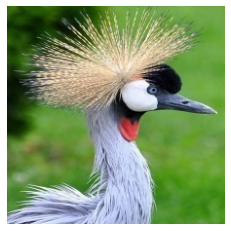

Class prediction vector =  [[1. 0.]]
Class:  tanager


In [70]:
predict_image(img_path+'images to test/1.jpg')
predict_image(img_path+'images to test/4.jpg')